In [14]:
import argparse

def build_argparser():
    parser = argparse.ArgumentParser()
    parser.add_argument('-m', '--model', help='Path to an .xml \
        file with a trained model.', required=True, type=str)
    parser.add_argument('-w', '--weights', help='Path to an .bin file \
        with a trained weights.', required=True, type=str)
    parser.add_argument('-i', '--input', help='Path to a folder with \
        images or path to an image files', required=True, type=str, nargs='+')
    parser.add_argument('-o', '--output_dir', help='Directory to save \
        segmented images', required=True, type=str)
    parser.add_argument('-b', '--batch_size', help='Size of the  \
        processed pack', default=1, type=int)
    parser.add_argument('-l', '--cpu_extension', help='MKLDNN \
        (CPU)-targeted custom layers.Absolute path to a shared library \
        with the kernels implementation', type=str, default=None)
    parser.add_argument('-pp', '--plugin_dir', help='Path to a plugin \
        folder', type=str, default=None)
    parser.add_argument('-d', '--device', help='Specify the target \
        device to infer on; CPU, GPU, FPGA or MYRIAD is acceptable. \
        Sample will look for a suitable plugin for device specified \
        (CPU by default)', default='CPU', type=str)
    parser.add_argument('--color_map', help='Classes color map', type=str,
        default=None)
    return parser

In [15]:
import sys
import logging as log
from openvino.inference_engine import IENetwork, IEPlugin

def prepare_model(model, weights, cpu_extension, device, plugin_dirs, log):
    model_xml = model
    model_bin = weights

    log.info('Creating plugin object for inference')
    plugin = IEPlugin(device=device, plugin_dirs=plugin_dirs)
    if cpu_extension and 'CPU' in device:
        plugin.add_cpu_extension(cpu_extension)

    log.info('Loading network files:\n\t{}\n\t{}'.format(model_xml, model_bin))
    net = IENetwork(model=model_xml, weights=model_bin)
    
    log.info('Checking layers are supported by plugin')
    if 'CPU' in plugin.device:
        supported_layers = plugin.get_supported_layers(net)
        not_supported_layers = [l for l in net.layers.keys() \
            if l not in supported_layers]
        if not_supported_layers:
            log.error('Following layers are not supported by the plugin for specified' 
                'device {}:\n {}'.format(plugin.device, ', '.join(not_supported_layers)))
            log.error('Please try to specify cpu extensions library path in sample\'s' 
                'command line parameters using -l or --cpu_extension command line'
                'argument')
            raise Exception('Unsupported network layers')
    return net, plugin

In [16]:
import os
import cv2
import numpy as np
import logging as log
from matplotlib import pyplot as plt

def get_image_list(input, log):
    log.info('Creating list of input images')
    if os.path.isdir(input[0]):
        data = [os.path.join(input[0], file) for file in os.listdir(input[0])]
    else:
        data = input
    return data

def convert_image(net, data, log):
    log.info('Getting shape of input tensor')
    n, c, h, w = net.inputs[next(iter(net.inputs))].shape
    log.info('Creating input images tensor')
    images = np.ndarray(shape=(len(data), c, h, w))
    for i in range(n):
        image = cv2.imread(data[i])
        
        plt.imshow(image)
        plt.show()
        
        if image.shape[:-1] != (h, w):
            image = cv2.resize(image, (w, h))
        image = image.transpose((2, 0, 1))
        images[i] = image
    return images

In [17]:
import numpy as np
from openvino.inference_engine import IENetwork, IEPlugin

def infer_sync(images, exec_net, net):
    input_blob = next(iter(net.inputs))
    out_blob = next(iter(net.outputs))
    res = exec_net.infer(inputs={input_blob : images})
    return res[out_blob]

In [18]:
import os
import cv2
import numpy as np
import logging as log
from itertools import product

def segmentation_output(res, color_map, output_dir, log):
    c = 3
    h, w = res.shape[2:]

    log.info('Reading color map')
    color_map = color_map or 'color_map.txt'
    classes_color_map = []
    with open(color_map, 'r') as f:
        for line in f:
            classes_color_map.append([int(x) for x in line.split()])

    log.info('Creating segmented images')
    result_images = []
    for batch, data in enumerate(res):
        classes_map = np.zeros(shape=(h, w, c), dtype=np.int)
        for i, j in product(range(h), range(w)):
            if len(data[:, i, j]) == 1:
                pixel_class = int(data[:, i, j])
            else:
                pixel_class = np.argmax(data[:, i, j])
            classes_map[i, j, :] = classes_color_map[min(pixel_class, 20)]
        out_img = os.path.join(output_dir, 'out_segmentation_{}.bmp'.format(batch))
        result_images.append(out_img)
        cv2.imwrite(out_img, classes_map)
        log.info('Result image was saved to {}'.format(out_img))
    return result_images

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def size2origin(input_images, output_images):
    for i in range(len(input_images)):
        original_image = cv2.imread(input_images[i])
        result_image = cv2.imread(output_images[i])
        height, width = original_image.shape[:-1]
        result_image = cv2.resize(result_image, (width, height))
        cv2.imwrite(output_images[i], result_image)
        
        plt.imshow(result_image)
        plt.show()

In [20]:
import sys
import logging as log

def main():
    log.basicConfig(format='[ %(levelname)s ] %(message)s',
        level=log.INFO, stream=sys.stdout)
    args = build_argparser().parse_args(sys.argv[3:])
    try:
        net, plugin = prepare_model(args.model, args.weights,
            args.cpu_extension, args.device, args.plugin_dir, log)
        net.batch_size = args.batch_size

        data = get_image_list(args.input, log)
        images = convert_image(net, data, log)

        log.info('Loading model to the plugin')
        exec_net = plugin.load(network=net)

        log.info('Starting inference')
        res = infer_sync(images, exec_net, net)

        log.info('Processing model output')
        res_images = segmentation_output(res, args.color_map, args.output_dir, log)

        log.info('Resize output images to origin size')
        size2origin(data, res_images)

        log.info('Free memory')
        del net
        del exec_net
        del plugin
    except Exception as ex:
        log.error(str(ex))
        raise ex

[ INFO ] Creating plugin object for inference
[ INFO ] Loading network files:
	dilation.xml
	dilation.bin
[ INFO ] Checking layers are supported by plugin
[ INFO ] Creating list of input images
[ INFO ] Getting shape of input tensor
[ INFO ] Creating input images tensor


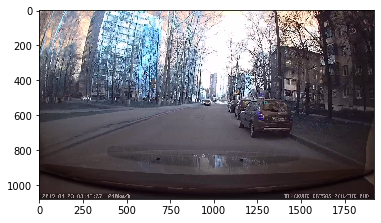

[ INFO ] Loading model to the plugin
[ INFO ] Starting inference
[ INFO ] Processing model output
[ INFO ] Reading color map
[ INFO ] Creating segmented images
[ INFO ] Result image was saved to ./out_segmentation_0.bmp
[ INFO ] Resize output images to origin size


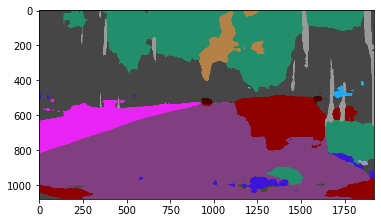

[ INFO ] Free memory


In [21]:
if __name__ == '__main__':
    sys.argv.append('--model=dilation.xml')
    sys.argv.append('--weights=dilation.bin')
    sys.argv.append('--input=image.jpg')
    sys.argv.append('--output_dir=./')
    sys.argv.append('--batch_size=1')
    sys.argv.append('--plugin_dir=c:/Program Files (x86)/IntelSWTools/openvino_2019.1.148/deployment_tools/inference_engine/bin/intel64/Release')
    sys.argv.append('--device=CPU')
    sys.argv.append('--color_map=color_map.txt')
    try:
        main()
    except:
        log.error('Execution stopped')